In [19]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the throwing arm swings back after initial motion
def is_throwing_arm_swinging_back(shoulder, elbow, wrist):
    """
    Determines if the throwing arm is swinging back after initial motion.
    The condition is met if the wrist moves significantly behind the shoulder in the x-axis.
    """
    shoulder_x, shoulder_y = shoulder
    elbow_x, elbow_y = elbow
    wrist_x, wrist_y = wrist

    # Arm is swinging back if the wrist is behind the shoulder in x-axis
    return wrist_x < shoulder_x - 0.1 and elbow_x < shoulder_x - 0.05

# Paths for the discus throwing videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage1/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage1/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for throwing arm analysis
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y]
                right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y]

                # Check if throwing arm is swinging back
                arm_swing_back = is_throwing_arm_swinging_back(right_shoulder, right_elbow, right_wrist)

                # Store data for this frame with standard Python booleans and float conversion
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "arm_swing_back": bool(arm_swing_back),
                    "right_shoulder": [float(coord) for coord in right_shoulder],
                    "right_elbow": [float(coord) for coord in right_elbow],
                    "right_wrist": [float(coord) for coord in right_wrist]
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Throwing arm swing analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737668453.360261 11561928 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737668453.462673 11608483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737668453.474180 11608484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Throwing arm swing analysis complete! JSON files saved in 'keypoints' folder.


In [21]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for throwing arm swing analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage1/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        with open(file_path, "r") as f:
            data = json.load(f)

        # Extract arm swing indicators across all frames
        arm_swing_data = [
            [int(frame["arm_swing_back"])]  # Extract arm swing flag
            for frame in data
        ]
        sequences.append(arm_swing_data)

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

        labels.append(label)

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 14 sequences with labels.


In [22]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 70


In [23]:
# Ensure consistent sequence length before splitting
max_length = max(len(seq) for seq in augmented_sequences)
augmented_sequences = pad_sequences(augmented_sequences, maxlen=max_length, padding='post', dtype='float32')

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Correct the reshaping based on the actual shape
num_timesteps = X_train.shape[1] // 2  # Assuming 2 features per timestep
X_train = X_train.reshape((X_train.shape[0], num_timesteps, 2))
X_val = X_val.reshape((X_val.shape[0], num_timesteps, 2))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 53, Validation samples: 17


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [25]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=8,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.6644 - mae: 0.6890 - val_loss: 0.5388 - val_mae: 0.6239
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.5155 - mae: 0.6322 - val_loss: 0.3399 - val_mae: 0.5470
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3244 - mae: 0.5300 - val_loss: 0.3079 - val_mae: 0.4055
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.2719 - mae: 0.3733 - val_loss: 0.2571 - val_mae: 0.4563
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1756 - mae: 0.3802 - val_loss: 0.2571 - val_mae: 0.4867
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.1871 - mae: 0.4088 - val_loss: 0.2647 - val_mae: 0.4701
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1740 - mae: 0.3471 - val_loss: 0.2710 - val_mae: 0.4360
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.1965 - mae: 0.3735 - val_loss: 0.2620 - val_mae: 0.4255
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2214 - mae:

In [26]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.2349, Validation MAE: 0.4069


In [27]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Predicted: 0.91, Actual: 0.00
Predicted: 0.69, Actual: 0.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.69, Actual: 0.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.93, Actual: 1.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.76, Actual: 0.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.92, Actual: 1.00
Predicted: 0.69, Actual: 0.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.90, Actual: 1.00
Predicted: 0.69, Actual: 1.00
Predicted: 0.91, Actual: 1.00
Predicted: 0.69, Actual: 0.00
Predicted: 0.70, Actual: 1.00


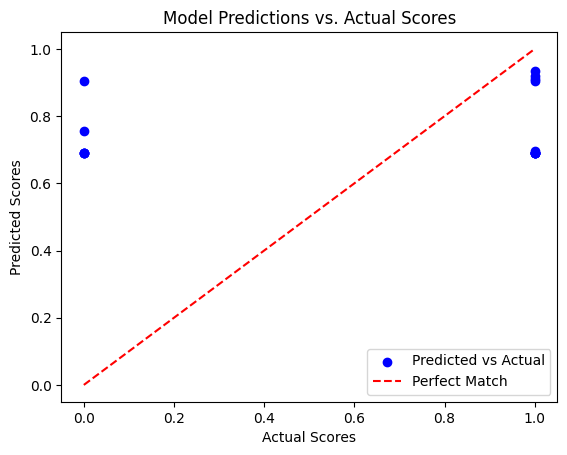

In [28]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [29]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the throwing arm swings back after initial motion
def is_arm_swinging_back(shoulder, elbow, wrist):
    """
    Determines if the throwing arm swings back after initial motion by analyzing
    the relative positions of the shoulder, elbow, and wrist.
    Conditions:
    - The wrist should move significantly behind the shoulder.
    - The elbow should be positioned further back than the shoulder.
    """
    shoulder_x, shoulder_y = shoulder
    elbow_x, elbow_y = elbow
    wrist_x, wrist_y = wrist

    arm_swung_back = wrist_x < elbow_x and elbow_x < shoulder_x
    return arm_swung_back

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage1/test_videos/1_user10.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for throwing arm swing analysis
        left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y]
        left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW].y]
        left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST].x, landmarks[mp_pose.PoseLandmark.LEFT_WRIST].y]

        right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
        right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW].y]
        right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x, landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y]

        # Check for throwing arm swinging back after initial motion
        left_swing = is_arm_swinging_back(left_shoulder, left_elbow, left_wrist)
        right_swing = is_arm_swinging_back(right_shoulder, right_elbow, right_wrist)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_swing), int(right_swing)])

cap.release()

# Pad the sequence to match training input length
max_seq_length = X_train.shape[1]  # Ensure it's the same length used during training
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Reshape to match model input (samples, timesteps, features)
new_keypoints_padded = new_keypoints_padded.reshape((new_keypoints_padded.shape[0], new_keypoints_padded.shape[1], 2))

# Predict score for the new video
predicted_score = model.predict(new_keypoints_padded)
print(f"Predicted Score: {predicted_score[0][0]:.2f}")

I0000 00:00:1737668815.487375 11561928 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737668815.544918 11650283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737668815.554231 11650294 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Predicted Score: 0.94


In [30]:
print(X_train.shape[1])

110


In [31]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.65:
        return 1.0
    elif prediction >= 0.4:
        return 0.5
    else:
        return 0.0

In [32]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 0.0
Classified: 1.0, Actual: 1.0


In [33]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [35]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Classification Accuracy: 0.65


In [36]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage1/models/discus_stage1.keras")